# Introduction

The goal of this notebook is to build function that will be used to make files that can be read by execute_PARCELS to seed particles in all sorts of configurations.

# Imports

In [5]:
# system
import sys
import os
from   importlib import reload

# maths
import numpy  as np
import xarray as xr

# plotting
import matplotlib.pyplot as pyp
import cartopy.crs       as ccrs
import cartopy.feature   as cfeature

# parcels
import parcels

In [6]:
sys.path.append(os.path.abspath('../execute'))

In [9]:
import execute_PARCELS as exP
import kernels
from fieldset_vars import FieldsetVariable

In [51]:
reload(exP)
reload(kernels)

<module 'kernels' from '/home/colin_beyers/lagrangian_drifts/execute/kernels.py'>

# Grid at Time Step 1

In [3]:
ds = xr.open_dataset('/home/colin_beyers/data/cllc-U,V,mag.nc4')
ds

<xarray.Dataset>
Dimensions:  (time: 10321, lat: 368, lon: 500)
Coordinates:
  * lat      (lat) float64 25.0 25.06 25.12 25.18 ... 46.84 46.9 46.96 47.02
  * lon      (lon) float64 -140.0 -139.9 -139.9 -139.8 ... -110.2 -110.1 -110.1
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-03-25
Data variables:
    U        (time, lat, lon) float64 ...
    V        (time, lat, lon) float64 ...
    mag      (time, lat, lon) float64 ...
Attributes:
    title:           Snapshot of California Coast Winds and Currents
    editor_name:     James Clemson
    editor_contact:  jclemson@mines.edu
    date_created:    Mon Jun 24 11:14:59 2024

In [64]:
def grid(dataset, lat_min=None, lat_max=None, lon_min=None, lon_max=None, density=1):
    # If lat_min, lat_max, lon_min, lon_max are None, set to the full domain minus one grid cell
    if lat_min is None:
        lat_min = dataset.lat.values[1]
    if lat_max is None:
        lat_max = dataset.lat.values[-2]
    if lon_min is None:
        lon_min = dataset.lon.values[1]
    if lon_max is None:
        lon_max = dataset.lon.values[-2]
    
    # Determine the grid spacing from the dataset
    lat_spacing = np.abs(dataset.lat.values[1] - dataset.lat.values[0])
    lon_spacing = np.abs(dataset.lon.values[1] - dataset.lon.values[0])

    # Calculate the scaling factors
    lat_scale_factor = density / (lat_spacing)  # Scale down by density (density=1 gives lat_spacing)
    lon_scale_factor = density / (lon_spacing)  # Scale down by density (density=1 gives lon_spacing)

    # Calculate scaled spacing
    scaled_lat_spacing = lat_spacing * lat_scale_factor
    scaled_lon_spacing = lon_spacing * lon_scale_factor

    # Create evenly spaced lists of longitudes and latitudes based on the scaled spacing
    lons = np.arange(lon_min, lon_max + scaled_lon_spacing, scaled_lon_spacing)
    lats = np.arange(lat_min, lat_max + scaled_lat_spacing, scaled_lat_spacing)

    # Create a grid of longitudes and latitudes
    lon_grid, lat_grid = np.meshgrid(lons, lats)

    # Check for NaN values in the dataset to create the land mask
    land_mask = np.isnan(dataset['U'].isel(time=0).interp(lon=lon_grid[0], lat=lat_grid[:,0]))

    # Apply the land mask: Set to NaN where there is land
    lon_grid[land_mask] = np.nan
    lat_grid[land_mask] = np.nan

    # Flatten the grids
    flat_lons = lon_grid.flatten()
    flat_lats = lat_grid.flatten()

    # Remove any NaN (land) values
    valid_lons = flat_lons[~np.isnan(flat_lons)]
    valid_lats = flat_lats[~np.isnan(flat_lats)]

    # Save to .txt files
    np.savetxt('lons.txt', valid_lons, fmt='%.6f')
    np.savetxt('lats.txt', valid_lats, fmt='%.6f')

    print(f"Saved {len(valid_lons)} longitude and latitude points to 'lons.txt' and 'lats.txt' respectively.")
    
    return valid_lats, valid_lons

In [65]:
lats, lons = grid(ds)

Saved 466 longitude and latitude points to 'lons.txt' and 'lats.txt' respectively.


## Implementation

In [52]:
config = exP.load_config('/home/colin_beyers/lagrangian_drifts/simulations/particle_seeding/config.json')

2024-10-04 15:34:33,214 - INFO - Loading configuration from /home/colin_beyers/lagrangian_drifts/simulations/particle_seeding/config.json


In [53]:
# Load the kernels dynamically based on the config
kernel_list = exP.load_kernels(config.get("kernels", []), parcels, kernels)

# Collect the extra variables required by the kernels
extra_vars = exP.collect_extra_vars(kernel_list)

# Add extra particle type variables to particle class
extra_particle_vars = []
for extra_var in extra_vars:
    if type(extra_var) == parcels.particle.Variable:
        extra_particle_vars.append(extra_var)
particles = parcels.JITParticle.add_variables(extra_particle_vars)

# Create the fieldset based on the provided config
fieldset = exP.create_fieldset(config)

# Add extra fieldset type variables to fieldset object
for extra_var in extra_vars:
    if isinstance(extra_var, FieldsetVariable):
        fieldset.add_constant(extra_var.name, extra_var.value(fieldset))
    else:
        fieldset.add_constant(extra_var.name, extra_var)

2024-10-04 15:34:33,433 - INFO - Loaded kernels: ['AdvectionRK4', 'TotalDistance', 'BoundaryCheck']
2024-10-04 15:34:33,433 - INFO - Collected extra variables for kernels: [PVar<distance|<class 'numpy.float32'>>, PVar<prev_lon|<class 'numpy.float32'>>, PVar<prev_lat|<class 'numpy.float32'>>, <FieldsetVariable lat_min>, <FieldsetVariable lat_max>, <FieldsetVariable lon_min>, <FieldsetVariable lon_max>]
2024-10-04 15:34:33,434 - INFO - Including a coastal boundary.
2024-10-04 15:34:33,435 - WARNING - No coastal boundary path provided. Assuming main path includes the coastal boundary already.
2024-10-04 15:34:33,465 - INFO - Fieldset created with filenames: /home/colin_beyers/data/CCS-U(wcb),V(wcb),mag-01202020_20292021.nc


In [54]:
# Create the ParticleSet based on the fieldset object and particle class
pset = exP.create_particle_set(fieldset, particles, config)

2024-10-04 15:34:33,684 - INFO - Loaded latitudes: [25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 25.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 26.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 27.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 28.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.06, 29.

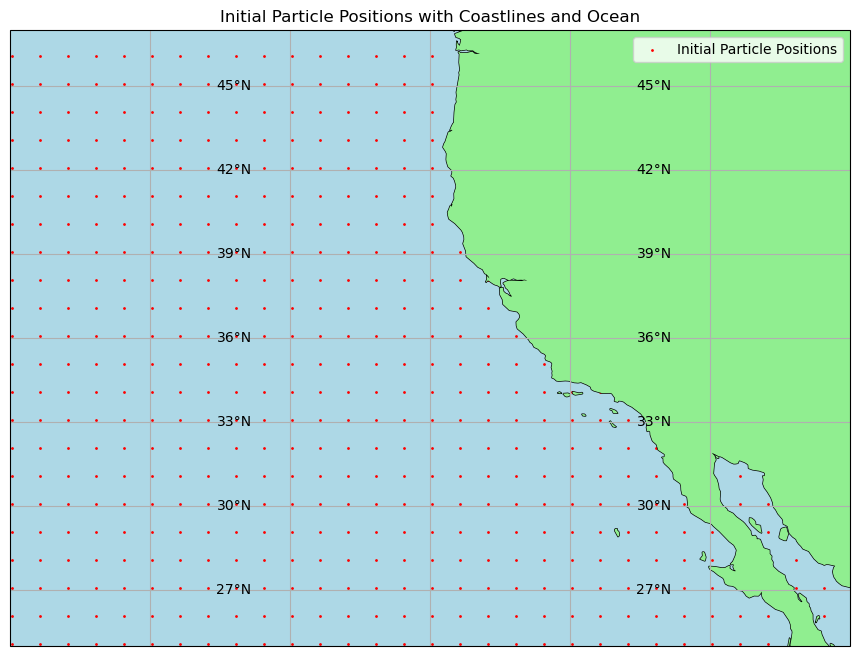

In [60]:
lons = pset.lon
lats = pset.lat

# Create a georeferenced plot with Cartopy
pyp.figure(figsize=(12, 8))
ax = pyp.axes(projection=ccrs.PlateCarree())

# Add coastlines and oceans
ax.coastlines()
ax.add_feature(cfeature.OCEAN, zorder=1, facecolor='lightblue')
ax.add_feature(cfeature.LAND, zorder=2, facecolor='lightgreen')
# ax.add_feature(cfeature.LAKES, zorder=2, facecolor='lightblue')
# ax.add_feature(cfeature.RIVERS, zorder=3, edgecolor='blue')

# Scatter plot of the particle positions
sc = ax.scatter(lons, lats, color='red', marker='o', label='Initial Particle Positions', s=1,transform=ccrs.PlateCarree())

ax.set_xlim([-140, -110])  # Set longitude limits
ax.set_ylim([25,47])    # Set latitude limits

# Set title and labels
pyp.title('Initial Particle Positions with Coastlines and Ocean')
pyp.xlabel('Longitude')
pyp.ylabel('Latitude')

# Add gridlines and a legend
ax.gridlines(draw_labels=True, dms=True, x_inline=True, y_inline=True)
pyp.legend()
pyp.show()